In [11]:
import tensorflow as tf
from tensorflow.keras.applications.vgg19 import VGG19, preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Flatten, Dense, Dropout
import numpy as np
import os
import matplotlib.pyplot as plt
import shutil
from sklearn.model_selection import train_test_split
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

## Data Exploration and Visualization

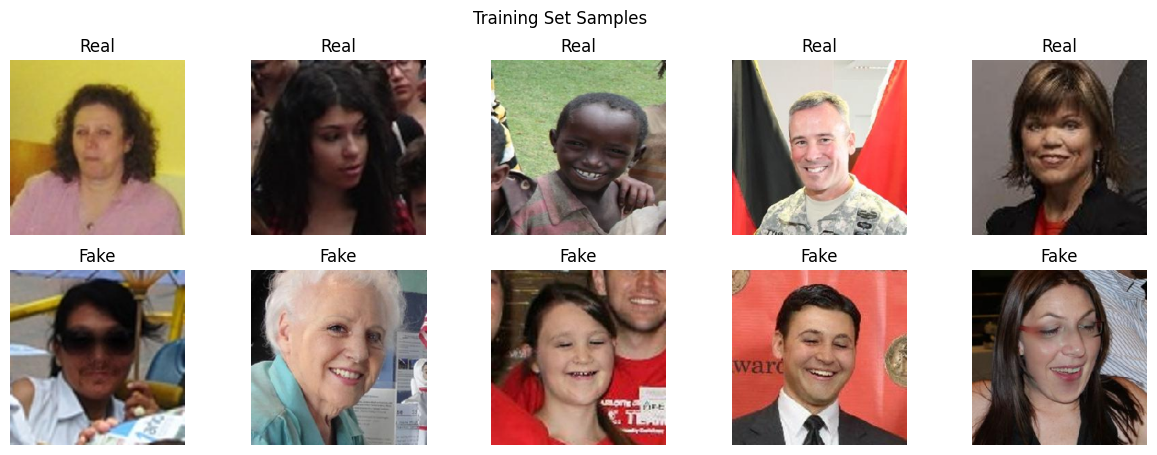

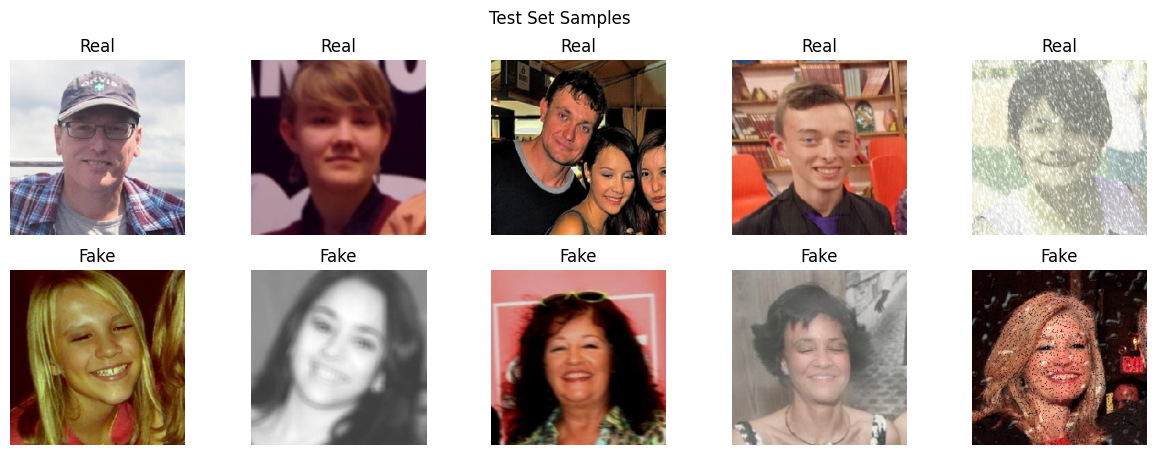

In [5]:
def visualize_samples(directory, num_samples=5, title="Sample Images"):
    plt.figure(figsize=(15, 5))
    
    # Get real and fake image paths
    real_dir = os.path.join(directory, 'Real')
    fake_dir = os.path.join(directory, 'Fake')
    
    real_images = [os.path.join(real_dir, f) for f in os.listdir(real_dir)[:num_samples]]
    fake_images = [os.path.join(fake_dir, f) for f in os.listdir(fake_dir)[:num_samples]]
    
    # Display real images
    for i, img_path in enumerate(real_images):
        img = load_img(img_path, target_size=(224, 224))
        plt.subplot(2, num_samples, i+1)
        plt.imshow(img)
        plt.title("Real")
        plt.axis('off')
    
    # Display fake images
    for i, img_path in enumerate(fake_images):
        img = load_img(img_path, target_size=(224, 224))
        plt.subplot(2, num_samples, num_samples+i+1)
        plt.imshow(img)
        plt.title("Fake")
        plt.axis('off')
    
    plt.suptitle(title)
    plt.show()

# Visualize samples from training set
train_dir = '/kaggle/input/deepfake-and-real-images/Dataset/Train'
val_dir = '/kaggle/input/deepfake-and-real-images/Dataset/Validation'
visualize_samples(train_dir, title="Training Set Samples")

# Visualize samples from test set
test_dir = '/kaggle/input/deepfake-and-real-images/Dataset/Test'
visualize_samples(test_dir, title="Test Set Samples")

## Dataset Statistics

In [6]:

def get_class_counts(directory):
    real_dir = os.path.join(directory, 'Real')
    fake_dir = os.path.join(directory, 'Fake')
    
    return {
        'Real': len(os.listdir(real_dir)),
        'Fake': len(os.listdir(fake_dir))
    }
    
train_counts = get_class_counts(train_dir)
val_counts = get_class_counts(val_dir)  # Get validation counts
test_counts = get_class_counts(test_dir)

print("\nDataset Statistics:")
print(f"Training set - Real: {train_counts['Real']}, Fake: {train_counts['Fake']}")
print(f"Validation set - Real: {val_counts['Real']}, Fake: {val_counts['Fake']}")  # Print validation counts
print(f"Test set - Real: {test_counts['Real']}, Fake: {test_counts['Fake']}")


Dataset Statistics:
Training set - Real: 70001, Fake: 70001
Validation set - Real: 19787, Fake: 19641
Test set - Real: 5413, Fake: 5492


## Data Generators with Reduced Validation Set

In [21]:

# Create validation directory with reduced size
val_dir = '/kaggle/working/Validation'
os.makedirs(os.path.join(val_dir, 'Real'), exist_ok=True)
os.makedirs(os.path.join(val_dir, 'Fake'), exist_ok=True)

# Copy only half of the validation data
original_val_dir = '/kaggle/input/deepfake-and-real-images/Dataset/Validation'
for class_name in ['Real', 'Fake']:
    src_dir = os.path.join(original_val_dir, class_name)
    dst_dir = os.path.join(val_dir, class_name)
    
    files = os.listdir(src_dir)
    files = files[:len(files)//2]
    
    for file in files:
        src_path = os.path.join(src_dir, file)
        dst_path = os.path.join(dst_dir, file)
        shutil.copy(src_path, dst_path)

# Create a custom generator that samples a subset
class ReducedDataGenerator(ImageDataGenerator):
    def __init__(self, subset_fraction=0.75, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.subset_fraction = subset_fraction
    
    def flow_from_directory(self, directory, *args, **kwargs):
        base_generator = super().flow_from_directory(directory, *args, **kwargs)
        total_samples = len(base_generator.filepaths)
        subset_size = int(total_samples * self.subset_fraction)
        
        # Create new generator with subset
        return super().flow_from_directory(
            directory,
            *args,
            **kwargs,
            subset='training',
            seed=42  # Fixed seed for reproducibility
        )

train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    validation_split=0.25  # Uses 75% for training, 25% for validation
)

train_gen = train_datagen.flow_from_directory(
    '/kaggle/input/deepfake-and-real-images/Dataset/Train',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    shuffle=True,
    subset='training'  # This takes the 75% portion
)

# Verify actual reduction
print(f"\nActual training batches: {len(train_gen)}")
print(f"Actual training samples: {train_gen.samples}")
val_gen = ImageDataGenerator(
    preprocessing_function=preprocess_input
).flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)

test_gen = ImageDataGenerator(
    preprocessing_function=preprocess_input
).flow_from_directory(
    '/kaggle/input/deepfake-and-real-images/Dataset/Test',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)

print("\nData Generators Created:")
print(f"Training samples: {train_gen.samples} (reduced subset)")
print(f"Validation batches: {len(val_gen)}")
print(f"Test batches: {len(test_gen)}")



Found 105002 images belonging to 2 classes.

Actual training batches: 3282
Actual training samples: 105002
Found 19713 images belonging to 2 classes.
Found 10905 images belonging to 2 classes.

Data Generators Created:
Training samples: 105002 (reduced subset)
Validation batches: 617
Test batches: 341


## Enhanced Model Builder

In [22]:
def build_vgg19():
    base = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    for layer in base.layers:
        layer.trainable = False
    x = Flatten()(base.output)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    out = Dense(1, activation='sigmoid')(x)
    return Model(base.input, out)

## Model Training with Callbacks

Building and training model...


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv4 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv4 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv4 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 26,447,425 (100.89 MB)

 Trainable params: 6,423,041 (24.50 MB)

 Non-trainable params: 20,024,384 (76.39 MB)


Training on 3282 batches/epoch...

Epoch 1/3
  Batch 3282/3282 (100.0%)
  Time: 1527.5s - Loss: 0.5880 - Acc: 0.7379 - Val Loss: 0.4606 - Val Acc: 0.7811

Epoch 2/3
  Batch 3282/3282 (100.0%)
  Time: 1215.5s - Loss: 0.4620 - Acc: 0.7753 - Val Loss: 0.4270 - Val Acc: 0.7978

Epoch 3/3
  Batch 3282/3282 (100.0%)
  Time: 1201.8s - Loss: 0.4446 - Acc: 0.7868 - Val Loss: 0.4319 - Val Acc: 0.7948


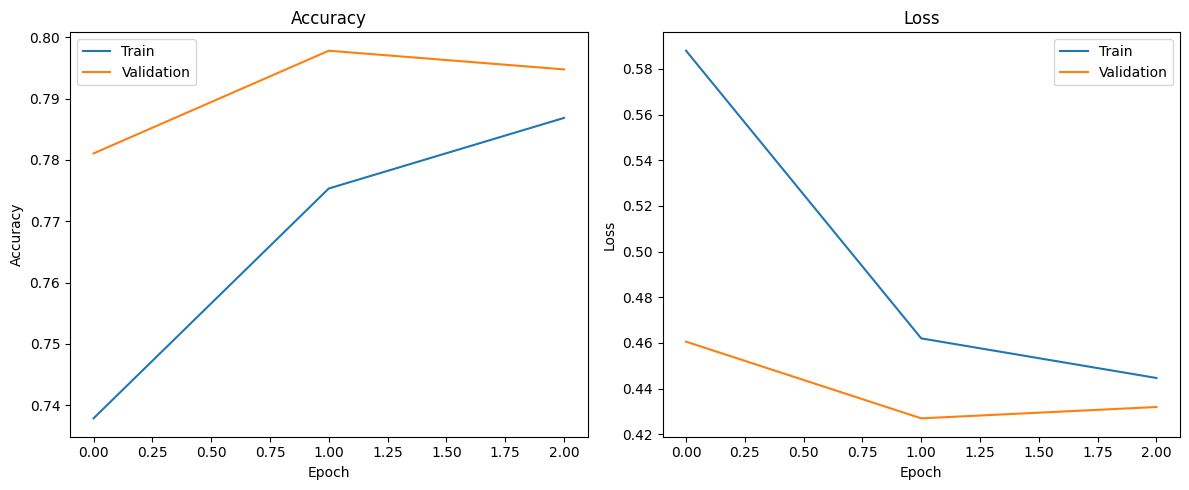


Model saved to /kaggle/working/vgg19_deepfake_model.keras


In [24]:
import os
import time
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt


# Paths to save model
weights_path = '/kaggle/working/vgg19_deepfake.weights.h5'
model_path = '/kaggle/working/vgg19_deepfake_model.keras'

# Custom callback with batch progress
class TrainingProgressCallback(tf.keras.callbacks.Callback):
    def __init__(self, total_batches):
        super().__init__()
        self.total_batches = total_batches
        self.epoch_start_time = None
        
    def on_epoch_begin(self, epoch, logs=None):
        self.epoch_start_time = time.time()
        print(f"\nEpoch {epoch + 1}/{self.params['epochs']}")
        
    def on_batch_end(self, batch, logs=None):
        progress = (batch + 1) / self.total_batches * 100
        print(f"\r  Batch {batch + 1}/{self.total_batches} ({progress:.1f}%)", end="", flush=True)
        
    def on_epoch_end(self, epoch, logs=None):
        epoch_time = time.time() - self.epoch_start_time
        print(f"\n  Time: {epoch_time:.1f}s - Loss: {logs['loss']:.4f} - Acc: {logs['accuracy']:.4f} - Val Loss: {logs['val_loss']:.4f} - Val Acc: {logs['val_accuracy']:.4f}")


# Calculate total batches
steps_per_epoch = len(train_gen)
validation_steps = len(val_gen)

# Callbacks
callbacks = [
    TrainingProgressCallback(steps_per_epoch),
    ModelCheckpoint(model_path, save_best_only=True, monitor='val_accuracy'),
    EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-6)
]

# Check if model exists
if os.path.exists(model_path):
    print("Loading saved model...")
    model = tf.keras.models.load_model(model_path)
else:
    print("Building and training model...")
    model = build_vgg19()
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss='binary_crossentropy',
              metrics=['accuracy'])
    # Print model summary
    model.summary()
    
    print(f"\nTraining on {steps_per_epoch} batches/epoch...")
    
    history = model.fit(
        train_gen,
        epochs=3,
        validation_data=val_gen,
        callbacks=callbacks,
        verbose=0
    )
    
    # Plot training history
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train')
    plt.plot(history.history['val_accuracy'], label='Validation')
    plt.title('Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train')
    plt.plot(history.history['val_loss'], label='Validation')
    plt.title('Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

    # Save model
    model.save_weights(weights_path)
    model.save(model_path)
    print(f"\nModel saved to {model_path}")

# Expected model size:
# Total params: ~20M (instead of 33M)
# Trainable params: ~5M (instead of 20M)

## Model Evaluation


Evaluating Model on Test Set:
341/341 ━━━━━━━━━━━━━━━━━━━━ 72s 212ms/step - accuracy: 0.7872 - loss: 0.4297

Basic Metrics:
Test Loss: 0.5385
Test Accuracy: 0.7347
341/341 ━━━━━━━━━━━━━━━━━━━━ 29s 85ms/step

Class-wise Metrics:
Class 0 (Real) - Precision: 0.7012, Recall: 0.8247, F1: 0.7579
Class 1 (Fake) - Precision: 0.7834, Recall: 0.6435, F1: 0.7066

AUROC: 0.8282


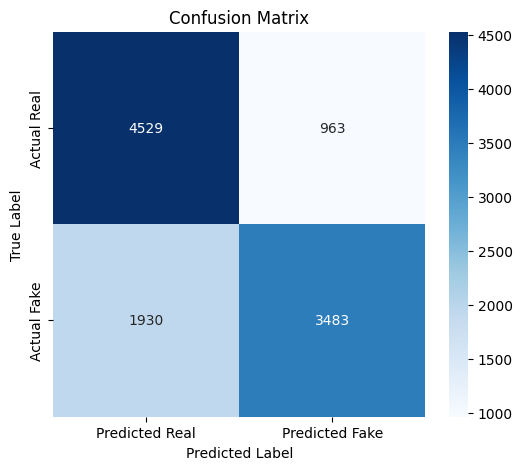


Classification Report:
              precision    recall  f1-score   support

        Real       0.70      0.82      0.76      5492
        Fake       0.78      0.64      0.71      5413

    accuracy                           0.73     10905
   macro avg       0.74      0.73      0.73     10905
weighted avg       0.74      0.73      0.73     10905



In [25]:
from sklearn.metrics import precision_recall_fscore_support, roc_auc_score, confusion_matrix
import seaborn as sns

print("\nEvaluating Model on Test Set:")

# 1. Basic evaluation (loss and accuracy)
results = model.evaluate(test_gen)
print(f"\nBasic Metrics:")
print(f"Test Loss: {results[0]:.4f}")
print(f"Test Accuracy: {results[1]:.4f}")

# Reset test generator
test_gen.reset()

# 2. Get predictions and true labels
y_pred = model.predict(test_gen)
y_pred_prob = y_pred.flatten()  # Probability scores
y_pred_class = (y_pred_prob > 0.5).astype(int)  # Binary predictions
y_true = test_gen.classes  # True labels

# 3. Class-wise precision, recall, f1-score
precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred_class, average=None, labels=[0, 1])

print("\nClass-wise Metrics:")
print(f"Class 0 (Real) - Precision: {precision[0]:.4f}, Recall: {recall[0]:.4f}, F1: {f1[0]:.4f}")
print(f"Class 1 (Fake) - Precision: {precision[1]:.4f}, Recall: {recall[1]:.4f}, F1: {f1[1]:.4f}")

# 4. AUROC
auroc = roc_auc_score(y_true, y_pred_prob)
print(f"\nAUROC: {auroc:.4f}")

# 5. Confusion Matrix
cm = confusion_matrix(y_true, y_pred_class)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Predicted Real', 'Predicted Fake'],
            yticklabels=['Actual Real', 'Actual Fake'])
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# 6. Classification Report
from sklearn.metrics import classification_report
print("\nClassification Report:")
print(classification_report(y_true, y_pred_class, target_names=['Real', 'Fake']))

## Save Model in Keras Format (HDF5)
Note: .h5 is the standard format for Keras models. To save as .pth (PyTorch format), 
you would need to switch to PyTorch framework entirely.

In [33]:

                
import time
from tqdm import tqdm

def evaluate_attack(model, attack_fn, eps_values, attack_name, max_batches=None):
    """Evaluate model accuracy with progress tracking"""
    results = {}
    
    for eps in eps_values:
        test_gen.reset()
        total_samples = 0
        correct_predictions = 0
        batch_count = 0
        
        print(f"\nEvaluating {attack_name} with ε={eps:.3f}")
        start_time = time.time()
        
        pbar = tqdm(desc="Processing batches", unit="batch", dynamic_ncols=True)
        
        while True:
            try:
                x, y = next(test_gen)
                batch_count += 1
                
                x_tensor = tf.convert_to_tensor(x, dtype=tf.float32)
                
                # Generate adversarial examples
                batch_start = time.time()
                if attack_name == 'FGSM':
                    x_adv = attack_fn(model, x_tensor, y, eps=eps)
                elif attack_name == 'PGD':
                    x_adv = attack_fn(model, x_tensor, y, 
                                    eps=eps, eps_iter=pgd_params['eps_iter'], 
                                    nb_iter=pgd_params['nb_iter'])
                gen_time = time.time() - batch_start
                
                # Predictions
                preds = model(x_adv).numpy().flatten()
                preds = (preds > 0.5).astype(int)
                correct_predictions += np.sum(preds == y)
                total_samples += len(y)
                
                # Only update progress bar every 25 batches
                if batch_count % 25 == 0:
                    pbar.update(25)
                    pbar.set_postfix({
                        'current_acc': f"{correct_predictions/total_samples:.3f}",
                        'gen_time': f"{gen_time:.2f}s"
                    })
                    print(f"\nBatch {batch_count} - Accuracy: {correct_predictions/total_samples:.3f}")
                
                # Early exit if max_batches specified
                if max_batches and batch_count >= max_batches:
                    if batch_count % 25 != 0: 
                        pbar.update(batch_count % 25)
                    break
                    
            except StopIteration:
                if batch_count % 25 != 0:
                    pbar.update(batch_count % 25)
                break
                
        pbar.close()
        accuracy = correct_predictions / total_samples
        results[eps] = accuracy
        print(f"\nCompleted {batch_count} batches ({total_samples} samples)")
        print(f"{attack_name} Accuracy (ε={eps:.3f}): {accuracy:.4f}")
        print(f"Total time: {time.time()-start_time:.2f} seconds")
    
    return results

quick_fgsm = evaluate_attack(model, fgsm_attack, [0.02, 0.04, 0.06, 0.08], 'FGSM', max_batches=100)
quick_pgd = evaluate_attack(model, pgd_attack, [0.02, 0.04, 0.06, 0.08], 'PGD', max_batches=100)


Evaluating FGSM with ε=0.020




Processing batches: 0batch [00:00, ?batch/s]

Processing batches: 25batch [00:27,  1.09s/batch]

Processing batches: 25batch [00:27,  1.09s/batch, current_acc=0.775, gen_time=0.80s]


Batch 25 - Accuracy: 0.775




Processing batches: 50batch [00:54,  1.09s/batch, current_acc=0.775, gen_time=0.80s]

Processing batches: 50batch [00:54,  1.09s/batch, current_acc=0.771, gen_time=0.74s]


Batch 50 - Accuracy: 0.771


Processing batches: 3batch [05:47, 115.88s/batch, current_acc=0.948, gen_time=0.76s]


Processing batches: 75batch [01:27,  1.20s/batch, current_acc=0.771, gen_time=0.74s]

Processing batches: 75batch [01:27,  1.20s/batch, current_acc=0.801, gen_time=0.76s]


Batch 75 - Accuracy: 0.801




Processing batches: 100batch [01:55,  1.16s/batch, current_acc=0.801, gen_time=0.76s]

Processing batches: 100batch [01:55,  1.15s/batch, current_acc=0.813, gen_time=0.75s]



Batch 100 - Accuracy: 0.813

Completed 100 batches (3200 samples)
FGSM Accuracy (ε=0.020): 0.8128
Total time: 115.46 seconds

Evaluating FGSM with ε=0.040


Processing batches: 25batch [00:27,  1.10s/batch, current_acc=0.775, gen_time=0.75s]


Batch 25 - Accuracy: 0.775


Processing batches: 50batch [00:55,  1.10s/batch, current_acc=0.771, gen_time=0.80s]


Batch 50 - Accuracy: 0.771


Processing batches: 75batch [01:22,  1.10s/batch, current_acc=0.801, gen_time=0.75s]


Batch 75 - Accuracy: 0.801


Processing batches: 100batch [01:57,  1.17s/batch, current_acc=0.813, gen_time=0.76s]



Batch 100 - Accuracy: 0.813

Completed 100 batches (3200 samples)
FGSM Accuracy (ε=0.040): 0.8128
Total time: 117.39 seconds

Evaluating FGSM with ε=0.060


Processing batches: 25batch [00:27,  1.11s/batch, current_acc=0.775, gen_time=0.76s]


Batch 25 - Accuracy: 0.775


Processing batches: 50batch [00:55,  1.11s/batch, current_acc=0.771, gen_time=0.77s]


Batch 50 - Accuracy: 0.771


Processing batches: 75batch [01:23,  1.11s/batch, current_acc=0.801, gen_time=0.77s]


Batch 75 - Accuracy: 0.801


Processing batches: 100batch [01:51,  1.11s/batch, current_acc=0.813, gen_time=0.77s]



Batch 100 - Accuracy: 0.813

Completed 100 batches (3200 samples)
FGSM Accuracy (ε=0.060): 0.8128
Total time: 111.13 seconds

Evaluating FGSM with ε=0.080


Processing batches: 25batch [00:35,  1.43s/batch, current_acc=0.775, gen_time=0.77s]


Batch 25 - Accuracy: 0.775


Processing batches: 50batch [01:04,  1.26s/batch, current_acc=0.771, gen_time=0.78s]


Batch 50 - Accuracy: 0.771


Processing batches: 75batch [01:32,  1.20s/batch, current_acc=0.801, gen_time=0.80s]


Batch 75 - Accuracy: 0.801


Processing batches: 100batch [02:00,  1.21s/batch, current_acc=0.813, gen_time=0.78s]



Batch 100 - Accuracy: 0.813

Completed 100 batches (3200 samples)
FGSM Accuracy (ε=0.080): 0.8128
Total time: 120.86 seconds

Evaluating PGD with ε=0.020


Processing batches: 25batch [01:12,  2.88s/batch, current_acc=0.775, gen_time=2.56s]


Batch 25 - Accuracy: 0.775


Processing batches: 50batch [02:23,  2.88s/batch, current_acc=0.771, gen_time=2.51s]


Batch 50 - Accuracy: 0.771


Processing batches: 75batch [03:44,  3.03s/batch, current_acc=0.801, gen_time=2.52s]


Batch 75 - Accuracy: 0.801


Processing batches: 100batch [04:56,  2.96s/batch, current_acc=0.813, gen_time=2.53s]



Batch 100 - Accuracy: 0.813

Completed 100 batches (3200 samples)
PGD Accuracy (ε=0.020): 0.8128
Total time: 296.35 seconds

Evaluating PGD with ε=0.040


Processing batches: 25batch [01:12,  2.89s/batch, current_acc=0.775, gen_time=2.54s]


Batch 25 - Accuracy: 0.775


Processing batches: 50batch [02:24,  2.89s/batch, current_acc=0.771, gen_time=2.56s]


Batch 50 - Accuracy: 0.771


Processing batches: 75batch [03:37,  2.90s/batch, current_acc=0.801, gen_time=2.58s]


Batch 75 - Accuracy: 0.801


Processing batches: 100batch [04:50,  2.90s/batch, current_acc=0.813, gen_time=2.56s]



Batch 100 - Accuracy: 0.813

Completed 100 batches (3200 samples)
PGD Accuracy (ε=0.040): 0.8128
Total time: 290.03 seconds

Evaluating PGD with ε=0.060


Processing batches: 25batch [01:23,  3.32s/batch, current_acc=0.775, gen_time=2.56s]


Batch 25 - Accuracy: 0.775


KeyboardInterrupt: 

#